# Generative Adversarial Networks

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## Constants

In [2]:
DATA_DIR = "/home/SharedData/intern_sayan/GAN/MNIST"

CHECKPOINT_DIR = "/home/SharedData/intern_sayan/GAN/"
CHECKPOINT_G = "mnist_gan_gen.pth"
CHECKPOINT_D = "mnist_gan_dis.pth"

SHOULD_CHECKPOINT = True
LOAD_CHECKPOINT = False

!mkdir -p gan_images

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
CUDA = 0
BATCH_SIZE = 64
EPOCHS = 120

img_shape = (1, 28, 28)
lr_g = 0.0002
lr_d = 0.00002
latent_dim = 100

## Data

# train batches: 938, # test batches: 157
train image: torch.Size([1, 28, 28])
test image: torch.Size([1, 28, 28])


Text(0.5,1,'Test')

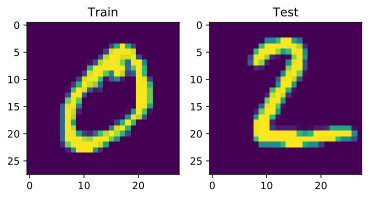

In [3]:
# Train Dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# Test Dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

print(f"# train batches: {len(train_loader)}, # test batches: {len(test_loader)}")

print(f"train image: {train_loader.dataset[0][0].size()}")
print(f"test image: {test_loader.dataset[0][0].size()}")

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(train_loader.dataset[1][0].reshape(28,28))
a.set_title("Train")

a = fig.add_subplot(1,2,2)
plt.imshow(test_loader.dataset[1][0].reshape(28,28))
a.set_title("Test")

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        
        return img

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        p_value = self.model(img_flat)

        return p_value

## Training

In [6]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Generator & Discriminator
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

if CUDA is not None:
    adversarial_loss.cuda(CUDA)
    generator.cuda(CUDA)
    discriminator.cuda(CUDA)
    
if LOAD_CHECKPOINT:
    generator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                      CHECKPOINT_G)))
    discriminator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                          CHECKPOINT_D)))
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))

[Epoch 120/120] [D loss: 498.77850342] [G loss: 1023.99194336] in 7.73 secs 


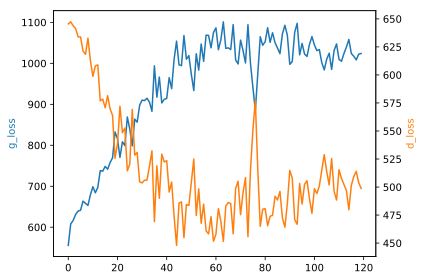

In [7]:
from IPython.display import clear_output
from tqdm import tqdm_notebook

losses = {"generator" : list(), "discriminator": list()}

def display_progress(delta, epoch, epoch_d_loss, epoch_g_loss):
    clear_output(True)
    
    print(f"[Epoch {(epoch+1):3}/{EPOCHS}] [D loss: {epoch_d_loss:.8f}] [G loss: {epoch_g_loss:.8f}] in {delta:.2f} secs ")
    
    fig, ax1 = plt.subplots()
    ax1.plot(range(len(losses["generator"])), losses["generator"], "tab:blue")
    ax1.set_ylabel("g_loss", color="tab:blue")
    
    ax2 = ax1.twinx()
    ax2.plot(range(len(losses["discriminator"])), losses["discriminator"], "tab:orange")
    ax2.set_ylabel("d_loss", color="tab:orange")

    fig.tight_layout()
    
    plt.show()
    

def sample_image(epoch):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    n_row = 8
    # Sample noise
    z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (n_row**2, latent_dim))))

    gen_imgs = generator(z)

    save_image(gen_imgs.data, "gan_images/epoch_{}.png".format(epoch), nrow=n_row, normalize=True)

    
Tensor = torch.cuda.FloatTensor if CUDA is not None else torch.FloatTensor

for epoch in range(EPOCHS):
    epoch_g_loss, epoch_d_loss = 0,0
    delta = time.time()
    
    for batch_idx, (imgs, _label) in tqdm_notebook(enumerate(train_loader)):
        # Adversarial ground truths
        valid = torch.autograd.Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = torch.autograd.Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = torch.autograd.Variable(imgs.type(Tensor))
        
        
        
        # Generator Training
        optimizer_G.zero_grad()
        
        # Sample noise as generator input
        z = torch.autograd.Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
            
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()
        
        
        
        # Discriminator Training
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        
        
        epoch_g_loss += g_loss.float()
        epoch_d_loss += d_loss.float()
        
        
    delta = time.time() - delta
    
    sample_image(epoch)
    
    losses["generator"].append(epoch_g_loss)
    losses["discriminator"].append(epoch_d_loss)
    
    if SHOULD_CHECKPOINT:
        torch.save(generator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                        CHECKPOINT_G))
        torch.save(discriminator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                            CHECKPOINT_D))
    
    display_progress(delta, epoch, epoch_d_loss, epoch_g_loss)
        

## Visualisation

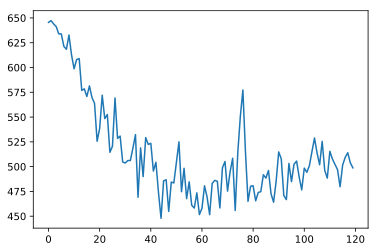

In [8]:
plt.plot(range(len(losses["discriminator"])), losses["discriminator"])

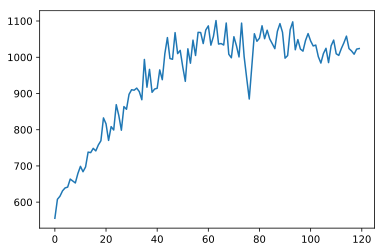

In [9]:
plt.plot(range(len(losses["generator"])), losses["generator"])

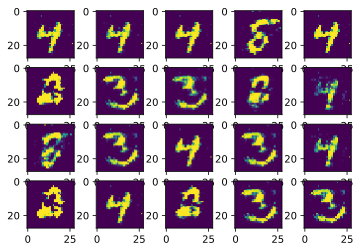

In [10]:
# Random sampling for inference
rows, cols = 4, 5
num_samples = rows * cols

if CUDA is not None:
    z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,1, (num_samples, latent_dim))).cuda(CUDA))
else:
    z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,1, (num_samples, latent_dim))))

image = generator(z).detach().cpu().numpy()

fig = plt.figure()

for row in range(rows):
    for col in range(cols):
        index = row*cols + col
        a = fig.add_subplot(rows, cols, index + 1)
        
        plt.imshow(image[index].reshape(28, 28))